In [12]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from math import *
from math import pi
from scipy.interpolate import interp1d

In [13]:
# define input histograms
# 'crys' is a crystalline sample with a large, diffuse amorphous background
# 'amorphous' is a histogram of just the diffuse scattering signal

# these files (below) were automatically generated from a piece of software, don't worry too much about them
# they are just example histograms
# all you need are arrays of Q vs Intensity
crys = pd.read_csv('crystalline.csv',header=25)
amorphous = pd.read_csv('amorphous.csv',header=25)


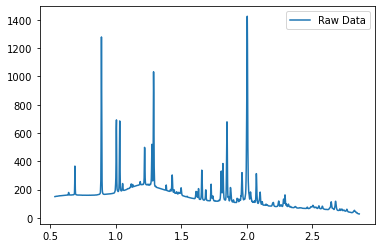

In [40]:
# choose one or the other samples
sample = crys
# samp = amorphous

# define x and 
x = sample['Q']
y = sample['y_obs']

plt.figure()
plt.plot(x,y,label='Raw Data')
plt.legend()
plt.show()

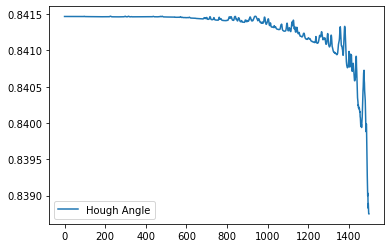

In [41]:
# calculate the hough transform of the diffraction histogram from a fixed point
# see wikipedia for explanation: https://en.wikipedia.org/wiki/Hough_transform
# in this case our fixed point will be (0,0) on the histogram plot

norm = np.array( np.sqrt(x**2 + y**2) )
ang = np.array( np.sin(y/norm) )

plt.figure()
plt.plot(ang,label='Hough Angle')
plt.legend()

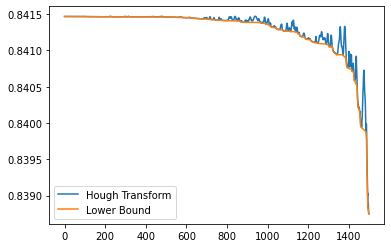

In [42]:
# now we're going to find the edge of the curve traced out by the hough transform
# create an array for storing values of the lower bound
store = np.zeros(len(x))
store[0] = ang[0]
store[-1] = ang[-1]
count = 0

# there is probably a better way of doing this
# if the angle of the vector increases, then we're off the boundary
for ii, item in enumerate(ang[1:-2]):

    if item < store[count]:
        store[ii] = item
        count= ii 
        
# fill in the zeros
z = np.where(store != 0)[0]
# store the q values of the boundary and their angles
lbound = np.array([x[z],store[z]])

plt.plot(ang,label='Hough Transform')
plt.plot(z,store[z],label='Lower Bound')
plt.legend()

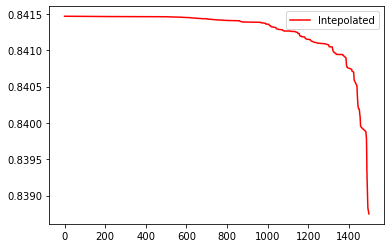

In [43]:
# fit a curve to the line
# I'm using a cubic spline
f = interp1d(lbound[0],lbound[1])

# create an array of len(x) that is fit with the spline
xnew = np.array(x)
bound = f(xnew)

plt.figure()
plt.plot(bound,'r',label='Intepolated')
plt.legend()

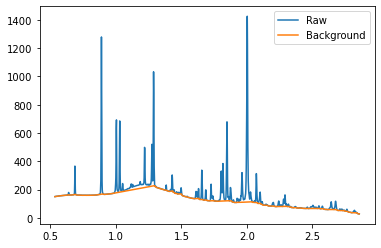

In [44]:
# transform back to q vs Intensity space
nI = np.sqrt( ((xnew**2)*np.arcsin(bound)**2) / (1 - np.arcsin(bound)**2))

# plot the data -- you'll notice that the background fit isn't great
plt.figure()
plt.plot(x,y,label='Raw')
plt.plot(x,nI,label='Background')
plt.legend()

In [45]:
# the following is a functionalized version of the process above
# function for doing background subtraction with a hough transform
def hough_bkg(x,y):
    norm = np.zeros(len(x))
    ang = np.zeros(len(x))

    for ii in np.arange(len(x)):
        norm[ii] = np.sqrt(x[ii]**2 + y[ii]**2)
        ang[ii] = np.sin(y[ii]/norm[ii])

    store = np.zeros(len(x))
    store[0] = ang[0]
    store[-1] = ang[-1]
    count = 0

    for ii, item in enumerate(ang):
        if ii == 0 or ii == len(x) - 1:
            continue

        if item < store[count]:
            store[ii] = item
            count= ii 


    # fill in the zeros
    z = np.where(store != 0)[0]
    # store the q values of the boundary and their angles
    lbound = np.array([x[z],store[z]])

    # fit a curve to the line
    # use cubic spline
    f = interp1d(lbound[0],lbound[1])

    # create an array of len(x) that is fit with the spline
    xnew = np.array(x)
    bound = f(xnew)

    # transform back to q vs Intensity space
    nI = np.zeros(len(xnew))
    for ii in range(0,len(xnew)):    
        nI[ii] = np.sqrt( ((xnew[ii]**2)*np.arcsin(bound[ii])**2) / (1 - np.arcsin(bound[ii])**2))

        
    return(nI)

<ipython-input-45-028f15e75dd3>:41: RuntimeWarning: invalid value encountered in double_scalars
  nI[ii] = np.sqrt( ((xnew[ii]**2)*np.arcsin(bound[ii])**2) / (1 - np.arcsin(bound[ii])**2))


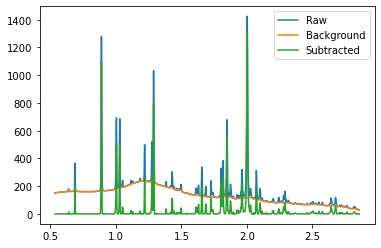

In [51]:
# Now we're going compute and re-compute the hough transform at multiple fixed points
# in order to get a better fit
# for this case, we're going to be scanning along the Q axis

# determine how many points you want to sample
# if you start to sample at EVERY point on the Q axis you will start to overfit
# so this step is a little hacky at the moment
start = 0
stop = len(x)
step = 100

# create an image for computing the hough transform at each fixed point
houghim = np.zeros([len(x[start:stop:step]),len(x)])

# compute and store the hough transform from each fixed point
for ind,xx in enumerate(x[start:stop:step]):
    # first compute the hough transform from (0,0)
    houghim[ind,:] = hough_bkg(x-xx,y)
    
# find the upper bound of each hough transform
bound = np.max(houghim,axis=0)

# plot the results
plt.figure()
plt.plot(x,y,label='Raw')
plt.plot(x,bound,label='Background')
plt.plot(x,y-bound,label='Subtracted')
plt.legend()

# feel free to zoom in and inspect the histogram closer -- the fit is not perfect
# it is overfitting in regions where there are multiple peaks
# plt.xlim(1.6,2.2)